# Navigation Project - Bharat Raman

---

In this project, I train an agent to navigate an environment filled with yellow and blue bananas. Collecting yellow bananas gives a reward of 1, while collecting blue bananas gives a reward of -1.
There are 37 state spaces, and 4 actions
- State spaces include the agent's velocity, and its ray-based perception of objects around its forward direction
- Actions include forward, backward, turn left, turn right

For the agent and model, I referred to the Lunar Landing exercise in this course.
- The model is a deep neural network consisting of four fully connected layers with ReLU activation.
- The agent will utilize a replay buffer to store tuples <S,A,R,S'> for each time step

This notebook is a modified version of the provided notebook for this project

## 1. Start the Environment

Make sure required packages are installed. See README.md for details

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
# please do not modify the line below
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 3. Define a model, agent and replay buffer

In [4]:
import random
from collections import namedtuple, deque

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

#### 3.1 Model

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """
        Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        
        "*** YOUR CODE HERE ***"
        #layer 1: Hidden
        self.fc1 = nn.Linear(state_size, 64)
        #layer 2: Hidden
        self.fc2 = nn.Linear(64, 128)
        #layer 3: Hidden
        self.fc3 = nn.Linear(128, 256)
        #layer 4: output
        self.fc4 = nn.Linear(256, action_size)

    def forward(self, state):
        #Build a network that maps state -> action values.
        state = F.relu(self.fc1(state)) #activation for first hidden layer
        state = F.relu(self.fc2(state)) #activation for second hidden layer
        state = F.relu(self.fc3(state)) #activation for third hidden layer
        state = F.relu(self.fc4(state)) #activation for outputyer
        return state

#### 3.2 Replay buffer

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, prioritize = False):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.prioritize = False
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### 3.3 Agent

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, 0).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, 0).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

#### Instantiate the agent

In [8]:
agent = Agent(state_size, action_size, 0)

## 4. Train

Train the agent to at most 1000 episodes.
Plot results

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [9]:
N_EPISODES = 1000     # maximum number of training episodes
MAX_T = 1000          # maximum number of timesteps per episode
EPS_START = 1.0       # starting value of epsilon, for epsilon-greedy action selection
EPS_END = 0.01        # minimum value of epsilon
EPS_DECAY = 0.995     # multiplicative factor (per episode) for decreasing epsilon




scores = []                                            # storing an array of scores for plotting
scores_window = deque(maxlen = 100)                    # Keeping track of 100 episodes' scores to gauge improvement
eps = EPS_START                                        # Initializing epsilon
best_average = 0
for i_episode in range(1, N_EPISODES+1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize score per episode
    for t in range(MAX_T):
        action = agent.act(state, eps)                 # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, 
                   next_state, done)
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        
        if done:                                       # exit loop if episode finished
            break
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(EPS_END, EPS_DECAY*eps) # decrease epsilon
    if i_episode % 10 == 0:
        print("Episode {}".format(i_episode))

    if np.mean(scores_window) > best_average:
        print('\r At Episode {}\tBest Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        best_average = np.mean(scores_window)
        if np.mean(scores_window)>=13.0:
            print('Parameters saved at Episode {:.2f}'.format(i_episode))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        if np.mean(scores_window) > 14:
            break
    
    


 At Episode 2	Best Average Score: 0.50
 At Episode 3	Best Average Score: 0.67
Episode 10
Episode 20
Episode 30
Episode 40
Episode 50
Episode 60
Episode 70
Episode 80
Episode 90
Episode 100
Episode 110
Episode 120
 At Episode 124	Best Average Score: 0.69
 At Episode 125	Best Average Score: 0.71
 At Episode 126	Best Average Score: 0.76
 At Episode 127	Best Average Score: 0.78
 At Episode 128	Best Average Score: 0.82
 At Episode 129	Best Average Score: 0.88
Episode 130
 At Episode 130	Best Average Score: 0.89
 At Episode 131	Best Average Score: 0.95
 At Episode 132	Best Average Score: 0.99
 At Episode 133	Best Average Score: 1.00
 At Episode 135	Best Average Score: 1.06
 At Episode 136	Best Average Score: 1.09
 At Episode 137	Best Average Score: 1.10
 At Episode 138	Best Average Score: 1.11
 At Episode 139	Best Average Score: 1.14
Episode 140
 At Episode 140	Best Average Score: 1.15
 At Episode 141	Best Average Score: 1.18
 At Episode 146	Best Average Score: 1.22
 At Episode 148	Best Aver

 At Episode 391	Best Average Score: 9.85
 At Episode 393	Best Average Score: 9.87
 At Episode 395	Best Average Score: 9.91
 At Episode 398	Best Average Score: 9.99
Episode 400
 At Episode 405	Best Average Score: 10.01
 At Episode 406	Best Average Score: 10.11
 At Episode 407	Best Average Score: 10.15
 At Episode 408	Best Average Score: 10.24
 At Episode 409	Best Average Score: 10.34
Episode 410
 At Episode 411	Best Average Score: 10.35
 At Episode 412	Best Average Score: 10.36
 At Episode 413	Best Average Score: 10.43
 At Episode 414	Best Average Score: 10.51
 At Episode 416	Best Average Score: 10.54
 At Episode 417	Best Average Score: 10.58
 At Episode 418	Best Average Score: 10.67
Episode 420
 At Episode 420	Best Average Score: 10.69
 At Episode 421	Best Average Score: 10.73
 At Episode 422	Best Average Score: 10.76
 At Episode 426	Best Average Score: 10.78
Episode 430
 At Episode 431	Best Average Score: 10.81
 At Episode 436	Best Average Score: 10.86
 At Episode 438	Best Average Sco

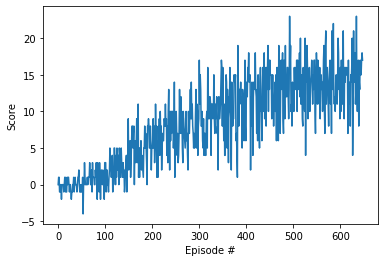

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Test Run
Do a test run to view the agent in action, and see how high a score it can now attain

In [16]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
while True:
    action = agent.act(state, eps)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    agent.step(state, action, reward, 
               next_state, done)
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:
        break
print("Score {}".format(score))

Score 15.0


When finished, you can close the environment.

In [17]:
env.close()

## 5. Conclusion
That the agent has managed to attain a reward average of 14 before 1000 episodes, it is safe to say that the neural network implemented is ideal for this project. A possible improvement to the model is an implementation of a prioritized experience-replay, where experiences are sampled based on their TD-error ($R_{t+1} + \gamma * max_a Q(S_{t+1},a, w) - Q(S_t,A_t,w)$), instead of at random. Other options include the dueling DQN, which mitigates overestimation of the current model, or the Dueling DQN, which identifies which states are valuable for training the agent.